In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 08, ASTR 596: Fundamentals of Data Science


## Time-series Analysis, p2

### Gautham Narayan 
##### <gsn@illinois.edu>

Borrowing heavily from Gordon Richards (Drexel)


# <center> Midterm solutions posted </center>


### <center> Policy Updates from the University </center>
<center> The deadline to drop a full-semester course is now April 30. </center>

<center> Students may select to take any course as credit/no-credit (CR/NC).</center>

### <center> Quick Review of Midterm </center>

## Recap

- Measurements  we looked at in the first half of this semester were all independent and identically distributed (i.i.d) 

# $$ P(x_1 \cap x_2) = P(x_1)\cdot P(x_2) $$

- You explictly **CANNOT** make this assumption with time-series data
    - Observations at time $t_n$ are **correlated** with potentially all previous observations
    - This **autocorrelation structure** is precisely what we are interested in
  

## The autocorrelation function 

Same as defintiion in week 6 for Markov Chains:

# $$\rho_X(k) = \frac{\text{Cov}(X_i, X_{i+k})}{\text{Var}(X_i)} $$

## The autocorrelation function 

Simple illustration - two apparently random numbers:

<table>
    <tr>
        <td><img src="acf.png" width=30%></td>
    </tr>
</table>

Blue is really $ y \sim 2\sin(5t) + N(0, 1)$ while orange is just $y \sim N(0, 1)$

If a the joint probability distribution of the measurements of the time-series does not change when shifted in time it is **stationary** - we used this term when we talked about Markov Chains, but there's a subtlety, because we don't mean exactly the same thing as in that context.

# 1. **Strict stationarity** 
   
 
## $$ X(t_1), X(t_2),...,X(t_n) = X(t_1+\tau), X(t_2+\tau),...,X(t_n+\tau) $$

for all $t_i$, all $n$ **and** all lags $\tau$

- Time-series which are stationary have autocorrelations that can only depend on the difference between two times i.e. $|t_i - t_j|$ rather than the actual coordinate value 

- This means that properties like the mean and variance of the process are constant with time
    - This is why we want our Markov Chains to be stationary
   
### A **strict stationary** process makes for a boring time-series because the moments are constant 
(note that constant doesn't mean finite - you could draw random samples and index them from a Cauchy distribution - the variance wouldn't be finite, but it is a strictly stationary process)

# 2. **Weak stationarity** 

- The first moment and the autocorrelation function need to be constant with time, and the variance must be finite
    - The autocorrelation must be constant with time != the autocorrelation must be the same for all lags
    - In particular, if there's a set of peaks in the autocorrelation function for specific lags $|t_i - t_j|$, that autocorrelation structure itself cannot change with time
        - Strictly stationary processes with finite variance are also weakly stationary, but not vice-versa
        
<table>
    <tr>
        <td><img src="example_ts.jpg" width=100%></td>
    </tr>
</table>

* a = strong stationary
* b = non-stationary but maybe can be detrended and transformed into c
* c = weak stationary 

# [More detailed description of stationarity in time-series](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

### If we say **stationary** and we're in the context of time-series, we do not mean strictly stationary as was the case with Markov Chains.

## Last class we looked at a radial velocity system

- you can write down a nice parametric model
    - i.e. there are analytic expressions for means and variances
*AND*
- the correlations between observations at $t_i$ and $t_i+\tau$ can be used to constrain the parameters of the model
    - i.e. the autocorrelation structure is special - **cyclostationary** 
        - repeats with integer multiples of the period - the underlying process is continious 
    
    
Because we a) had a model and b) the observations had strong correlations (you estimated the period reasonably by eye!)
- if you are lucky enough to have a model
- and can write down likelihood and priors
then you get to use all the machinery from the first half of this semester to infer the correlation structure.

In general, you don't get this lucky. You don't have a simple model and the correlation structure isn't this nice.

# What we are going to cover next:

We'll remove each of these conditions one at a time.
Today:
- simple strong correlation, no parametric model, stationary, continious (e.g. cepheids)
- complex correlation, no parametric model, stationary, continious (e.g. sunspots)
    - non-stationary, continious (e.g. AGN) aren't really much different

Next week:    
- discontinious (e.g. Supernovae <3<3<3 - these are the bestest!)

## Fourier Analysis

You can express any periodic signal as a sum of sines within noise, given sufficiently many components $M$ 

## $$y_i(t_i) = Y_o + \sum_{m=1}^M \beta_m \sin(m \omega t_i + \phi_m)   + \epsilon_i$$


Here's an illustration from the ICVG text of reconstructing a model RR Lyrae lightcurve with $k$ sine waves.

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import astroML.datasets.rrlyrae_templates
from astroML.datasets import fetch_rrlyrae_templates

In [3]:
%%capture

# RUN THIS

# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    # reconstruct using k frequencies
    y_fft = np.fft.fft(y) # compute FFT
    y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
    y_fit = np.fft.ifft(y_fft).real # reconstruct using k modes

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

fig = plt.gcf();

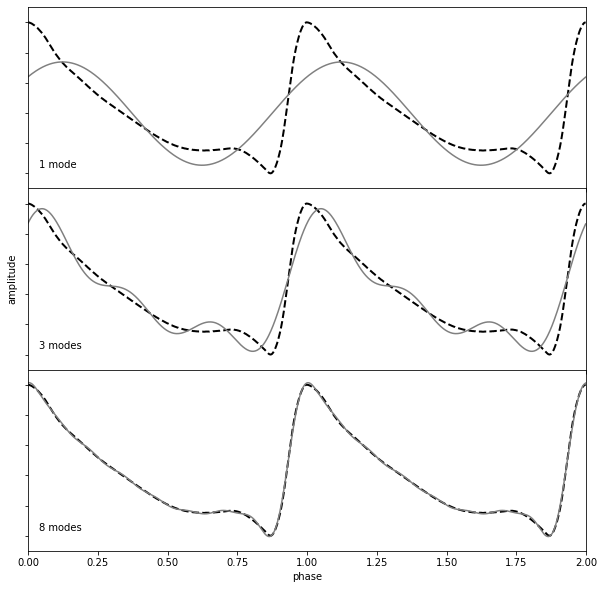

In [4]:
fig

The Fourier Transform by itself can be powerful if 
1. the signal-to-noise is high
2. the signal is continious and uniformly sampled 
3. the shape you are modeling is simple and can be decomposed into a few Fourier terms.

These are not the usual conditions we have when taking data. 

The figure on the left is the kind of data that you **want** to have, whereas the figure on the right is the kind of data that you are more likely to actually have.
<img src="rrlyrae-good.png" style="float: left; width: 40%; margin-right: 1%;"> <img src="rrlyrae-bad.png" style="float: left; width: 40%; margin-right: 1%;">

# The Periodogram

What we want to be able to do is to detect variability and measure the period in the face of both noisy and incomplete data. Instead we'll use Fourier decomposition to get a more useful tool for actual data analysis.


or a periodic signal we have:

$$y(t+P)=y(t),$$ where $P$ is the period.

We can create a *phased light curve* that plots the data as function of phase:
$$\phi=\frac{t}{P} − {\rm int}\left(\frac{t}{P}\right),$$

where ${\rm int}(x)$ returns the integer part of $x$.

### A Single Sinusoid

Let's take the case where the data are drawn from a single sinusoidal signal:

# $$y(t)=A \sin(\omega t+\phi)+\epsilon$$

and determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.


This model is annoying to work with because it's **non-linear** in the frequency term, $\omega$ and the phase, $\phi$

We can rewrite the argument as $\omega(t−t_0)$ (reexpressing the phase term) and use trig identies to rewrite the model as: 

# $$y(t)=a \sin(\omega t)+b \cos(\omega t)$$

where 

# $$A=(a^2+b^2)^{1/2} \text{ and } \phi=\tan^{−1}(b/a)$$

The model is now linear with respect to coefficients $a$ and $b$ (and nonlinear only with respect to frequency, $\omega$). So we got rid of one of the two non-linear parameters!

Assuming constant uncertainties on the data, we can write a likelihood function down:

### $$L =\prod^N_{j=1}\frac{1}{\sqrt{2\pi}\sigma} \exp \left(\frac{−[y_j−a \sin(\omega t_j)−b \cos(\omega t_j)]^2}{2\sigma^2} \right) $$

where $y_i$ is the measurement (e.g., the brightness of a star) taken at time $t_i$.

### And now there's a bunch of math...


Assuming uniform priors on $a, b, \omega$, and $\sigma$ (which gives nonuniform priors on $A$ and $\phi$) the posterior can be simplified to:

# $$p(\omega,a,b,\sigma|{t,y}) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right)$$


with

> $Q= V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega) - a\, b\, M(\omega) - {1 \over 2} a^2 \, S(\omega) - {1 \over 2} b^2 \,C(\omega)\right]$

and

> $            V = {1\over N} \sum_{j=1}^N y_j^2$

> $       I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j)$

> $ R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$

> $      M(\omega) = \sum_{j=1}^N \sin(\omega t_j) \, \cos(\omega t_j)$

> $      S(\omega) = \sum_{j=1}^N \sin^2(\omega t_j)$

> $ C(\omega) = \sum_{j=1}^N  \cos^2(\omega t_j)$

**NOTE I, R, M, S, C only depend on $\omega$ and the data**

If N>>1 and we have data that extends longer than the period

$S(\omega) \approx C(\omega) \approx N/2$ and $M(\omega) \ll N/2$ and

>$Q \approx V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega)\right]  + {1 \over 2} (a^2 + b^2)$

### The posterior for many, randomly spaced, observations


If we marginalize over $a$ and $b$ (as we are interested in the period)

## $$  p(\omega,\sigma|\{t,y\}) \propto  \sigma^{-(N-2)} \exp \left( { - N V \over 2 \sigma^2} + { P(\omega) \over \sigma^2}       \right)$$

with 

## $$P(\omega) = {1 \over N} [ I^2(\omega) + R^2(\omega)]$$

## $$             V = {1\over N} \sum_{j=1}^N y_j^2$$

## $$       I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j)$$

## $$ R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$$

If we know the noise $\sigma$ then 

# $$   p(\omega|\{t,y\}, \sigma) \propto \exp \left( { P(\omega) \over \sigma^2} \right)$$

and we now have the posterior for $\omega$! 

$P(\omega)$ is the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is just a plot of the "power" at each possible period

So the process is similar to what we did with maximum likelihood estimation
1. Get some data
2. Make a uniform grid in period
3. Evaluate the likelihood/the periodogram power at each period 
4. Identify the period with the maximum power

<img src="periodogram.png">

### Significance of the peaks in the periodogram

The amplitude(s) of the periodic signal can be derived from the posterior in much the same way as we do for MLE i.e. take the derivative of the posterior with respect to $a$ and $b$, equate to 0 and find where the maximum is.

But what we really want to know is the "best value" $\omega$? 

The $\chi^2$ is given by
$$\chi^2(\omega) \equiv {1 \over \sigma^2} \sum_{j=1}^N [y_j-y(t_j)]^2 =
  {1 \over \sigma^2} \sum_{j=1}^N [y_j- a_0\, \sin(\omega t_j) - b_0 \, \cos(\omega t_j)]^2$$
  
which we can simplify to

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right]$$

where, again, $P(\omega)$ is the periodogram and $\chi_0^2$ is the $\chi^2$ for a model with $y(t)$=constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We'll now renormalise the periodogram, defining the [Lomb-Scargle periodogram](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb.E2.80.93Scargle_periodogram) as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$  where $0 \le P_{\rm LS}(\omega) \le 1$.

With this renormalization, the reduction in $\chi^2(\omega)$ for the harmonic model, 
relative to $\chi^2$ for the pure noise model, $\chi^2_0$ is
$${\chi^2(\omega) \over \chi^2_0}=  1 - P_{LS}(\omega).$$

To determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model.

If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$ and the $\chi^2$ at $\omega = \omega_0$ is $N$.

If the true frequency is $\omega_0$ then the maximum peak in the periodogram should have a height

$$P(\omega_0) = {N \over 4} (a_0^2 + b_0^2)$$

and standard deviation
$$      \sigma_P(\omega_0)  = {\sqrt{2} \over 2} \, \sigma^2.$$


# Properties of LS and the periodogram

- The expected heights of the peaks in a periodogram don't depend on $\sigma$ but their variation in height do.
- For $P_{\rm LS}(\omega_0)$, with no noise the peak approaches 1. As noise increases, $P_{\rm LS}(\omega_0)$ decreases and is ``buried'' in the background  noise.
- Our derivation worked for mean = 0, and data in a single channel/passband
    - Extensions of Lomb-Scargle to multiple passbands and to handle a floating mean + many numerical approximations
    
## [Jake VanDerPlas has a good writeup on understanding the periodogram](https://arxiv.org/abs/1703.09824)

# In-class Exercise: Finding the Period of a Variable Star

If you don't already have gatspy, you'll want it:

> `conda install gatspy`

There are alternatives but none are as good.

There is some data in a file below.

1. Plot it up to see what it looks like
2. Use the Lomb-Scargle Multiband to construct a periodogram on a grid of a 1000 periods
3. Plot the folded light curve for the best-guess period

In [5]:
# RUN THIS
import astropy.table as at
from gatspy.periodic import LombScargleMultiband

data = at.Table.read('1938779.dat', format='ascii')

t     = data['HJD']
y     = data['MAG']
dy    = data['MAGERR']
filts = data['FILTS']

data

HJD,MAG,MAGERR,CONTAM,SKYLO,SKYHI,BLIM,TYPE,CHIP,XP,YP,FILTS
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1
56423.713908,19.136,0.02,0.0,22.19,30.6,0.088,1.0,4.0,163.44,1993.44,u
56423.862091,19.07,0.016,0.0,22.93,31.95,0.085,1.0,4.0,70.75,2060.01,u
56424.694922,19.209,0.021,0.0,19.38,28.98,0.089,1.0,4.0,147.53,2012.44,u
56424.77499,18.982,0.019,0.0,42.83,68.57,0.089,1.0,4.0,116.54,2031.77,u
56424.86045,19.054,0.015,0.0,39.22,57.04,0.079,1.0,4.0,132.58,2006.13,u
56450.659293,19.255,0.017,0.0,18.3,26.51,0.087,1.0,4.0,250.52,1937.43,u
56450.785196,18.935,0.017,0.0,21.16,30.51,0.082,1.0,4.0,193.17,1973.04,u
56450.883668,19.197,0.019,0.0,26.06,35.37,0.087,1.0,4.0,203.26,1970.1,u
56450.936075,19.248,0.022,0.0,46.57,56.34,0.096,1.0,4.0,206.95,1993.73,u


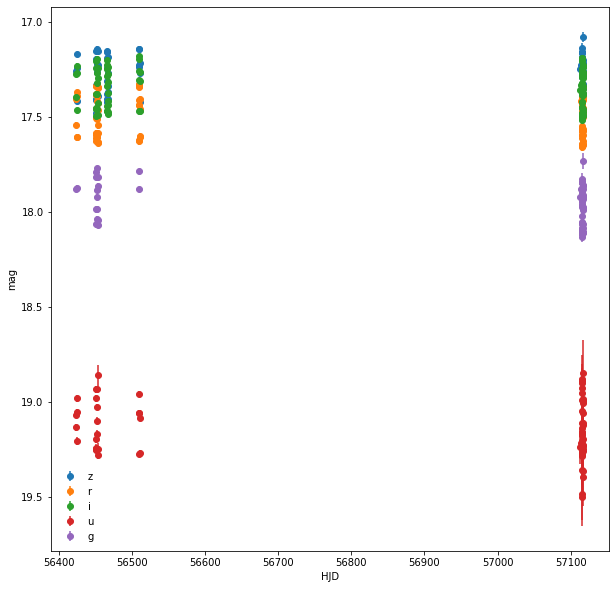

In [6]:
# PLOT THE DATA IN EACH PASSBAND - YOUR CODE HERE
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
for pb in set(filts):
    ind = (filts == pb)
    ax.errorbar(t[ind], y[ind], yerr=dy[ind], marker='o', ls='None', label=pb)
ax.legend(frameon=False)
ax.set_xlabel('HJD')
ax.set_ylabel('mag')
ax.invert_yaxis()
    

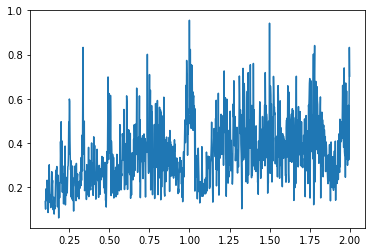

In [7]:
# YOUR CODE HERE


# You can set the number of terms in the Lomb-Scargle periodogram, either baseline or by band
model = LombScargleMultiband(Nterms_base=9, Nterms_band=0)
model.fit(t, y, dy, filts)

# CREATE A GRID OF PERIODS THAT IS REASONABLE - YOUR CODE HERE
# CALL YOUR VARIABLE `periods`
periods = np.linspace(0.1, 2, 1000)

# YOU CAN COMPUTE THE PERIODOGRAM WITH:
power = model.periodogram(periods)

# PLOT THE PERIODOGRAM
plot(periods, power)

In [8]:
# YOU CAN SET THE RANGE FOR THE PERIOD SEARCH TO NARROW THINGS DOWN
model.optimizer.period_range = (0.2, 0.8)

# WITHIN THIS NARROW RANGE LOMB-SCARGLE CAN GIVE YOU THE BEST PERIOD
period = model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 0.8
 - Computing periods at 12999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


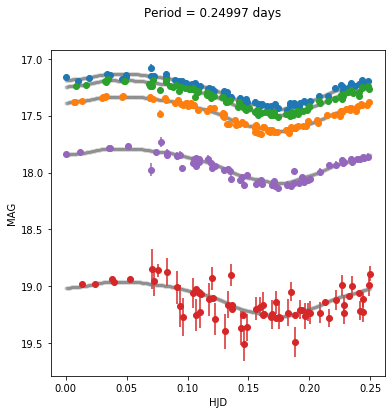

In [9]:
# RUN THIS TO LOOK AT YOUR FOLDED LIGHT CURVE

tfit = np.linspace(0, period, 1000)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
for pb in set(filts):
    pfilt = [pb,]*len(tfit)
    yfit = model.predict(tfit, filts=pfilt)
    ax.plot(tfit, yfit, linestyle='-', marker='.', color='grey', alpha=0.1)
    ind = (filts == pb)
    ax.errorbar(t[ind]%period, y[ind], yerr=dy[ind], linestyle='None', marker='o')
ax.set_xlabel('HJD')  
ax.set_ylabel('MAG')
fig.suptitle(f'Period = {period:.5f} days')
ax.invert_yaxis()

# What the periodogram is good for and what it isn't

Pros:
- Works with unevenly sampled data, and binning in phase helps build statistics even with noisy data

Cons:
- ANY PERIODIC SIGNAL IN THE DATA WILL EXHIBIT SOME POWER
    - This includes aliases of the true period
- Multiband extension requires  that the period/frequency is the same across all channels/passbands 
    - this is not the case for many time-series phenomena


<img src="Sun-Wavelength-Chart.jpg">



## Analysis of Stochastic Processes

If a system is always variable, but the variability is not (infinitely) predictable, then we have a [**stochastic**](https://en.wikipedia.org/wiki/Stochastic) process.  

Stochastic does not mean you cannot characterize this process, and make statistical statements about it.

<img src="quasar_schema.png" style="float: left; width: 40%; margin-right: 1%;"> <img src="ngc4261-large.jpg" style="float: left; width: 50%; margin-right: 1%;">

Take a (stochastically varying) quasar which has both *line* and *continuum* emission and where the line emission is stimulated by the continuum.  Since there is a physical separation between the regions that produce each type of emission, we get a delay between the light curves as can be seen here:

![Peterson 2001, RM](https://ned.ipac.caltech.edu/level5/Sept01/Peterson2/Figures/figure24.jpg)

## The correlation function

Instead of the auto-correlation function, we can look at the more general correlation function - this gives us information about the time delay between 2 processes.  

If one time series is derived from another simply by shifting the time axis by $t_{\rm lag}$, then their correlation function will have a peak at $\Delta t = t_{\rm lag}$.

The correlation function between $f(t)$, and $g(t)$ is defined as
# $${\rm CF}(\Delta t) = \frac{\lim_{T\rightarrow \infty}\frac{1}{T}\int_T f(t)g(t+\Delta t)dt }{\sigma_f \sigma_g}$$

Computing the correlation function is basically the mathematical processes of sliding the two curves over each other and computing the degree of similarity for each step in time.  

The peak of the correlation function reveals the time delay between the processes.  Below we have the correlation function of the line and continuum emission from a quasar, which reveals a $\sim$ 15 day delay between the two.

![Peterson 2001, RM](https://ned.ipac.caltech.edu/level5/Sept01/Peterson2/Figures/figure25.jpg)

### What can the ACF tell us?

If the values of $y$ are uncorrelated, then ACF$(\Delta t)=0$ (except for ACF$(0)=1$).

For processes that "retain memory" of previous states only for some characteristic time $\tau$, the ACF will vanish for $\Delta t \gg \tau$.

Turning that around, the predictability of future behavior of future behavior of such a process is limited to times up to $\sim \tau$; you have to "let the process run" to know how it will behave at times longer than that.

### The Structure Function

The *structure function* is another quantity that is frequently used in astronomy and is related to the ACF:

# $${\rm SF}(\Delta t) = {\sigma}_\infty[1 - {\rm ACF}(\Delta t)]^{1/2}$$

where ${\sigma}_\infty$ is the standard deviation of the time series as evaluated on timescales much larger than any charateristic timescale.

The structure function is interesting because it's equal to the standard deviation of the distribution of the differences of $y(t_2) - y(t_1)$ evaluated at many different $t_1$ and $t_2$ (i.e., with a time lag of $\Delta t = t_2 - t_1$), and divided by $\sqrt 2$.

This is of practical use: if I have a series of observations $y_i$ (taken at random times $t_i$) it's relatively straighforward to compute the structure function.

### Damped Random Walk

A DRW is described by a stochastic differential equation which includes a damping term that pushes $y(t)$ back towards the mean, hence the name **damped random walk**.   

The ACF for a DRW is given by

# $$ ACF(t) = \exp(-t/\tau)$$
where $\tau$ is the characteristic timescale (i.e., the damping timescale).

The DRW structure function can be written as
# $$ SF(t) = \sigma_{\infty}[1-\exp(-t/\tau)]^{1/2}$$

# Notice what's happening

We are **not** writing down a model for the observations directly anymore (they are a stochastic process so what'd be be the point)

**We are writing down a model for how the observations are correlated with each other**

###  Structure Function for Dampled Random Walk

<img src="MacLeod2010.png" alt="Drawing" style="width: 500px;"/>

The SF example above was an example of a DRW: the light curve is strongly correlated a short timescales, but uncorrelated at long timescales. 

This is observed in optical variability of quasar continuum light; in fact, it works so well that one can use this model to distinguish quasars from stars, based solely on the variability they exhibit.

If you can make the ACF or SF, then you can jolly well take it's Fourier Transform to get the:

### Power Spectral Density

The Fourier Transform of an ACF is the [Power Spectral Density (PSD)](https://en.wikipedia.org/wiki/Spectral_density).  So, the PSD is an analysis in frequency space and the ACF is in time space.

(the Wiener-Khinchin theorem describes the fact that the ACF and PSD are a Fourier pair) 

For example, for a sinusoidal function in time space, the ACF will have the same period, $T$. Conversly, the PSD in frequency space will be a $\delta$ function centered on $\omega = 1/2\pi T$.

For our nice quasar without an analytic model but with an analytic form for the ACF, the PSD is then:

# $$ PSD(f) = \frac{\tau^2 \sigma_{\infty}^2}{1+(2\pi f \tau)^2}$$

which means that a DRW is a $1/f^2$ process at high frequency. The **damped** part comes from the flat PSD at low frequency.

More generically, if 

## $${\rm SF} \propto t^{\alpha}$$

then 

## $${\rm PSD} \propto \frac{1}{f^{1+2\alpha}}$$

So an analysis of a stochastic system can be done with either the ACF, SF, or PSD.

### Different stochastic processes can be categorized based on their ACF/PSD

* A stochastic process with $1/f^2$ spectrum is known as random walk (if discrete) or Brownian motion (or, more accurately, Wiener process) if continuous. These physically occur when the value being observed is subjected to a series of independent changes of similar size. It's also sometimes called as "red noise". Quasar variability exhibits $1/f^2$ properties at high frequencies (that is, short time scales, below a year or so). 

* A stochastic process with $1/f$ spectrum are sometimes called "long-term memory processes" (also sometimes know as "pink noise"). They have equal energy at all octaves (or over any other logarithmic frequency interval). This type of process has infinite variance and an undefined mean (similar to a Lorentzian distribution). 

* A process with a constant PSD is frequently referred to as "white noise" -- it has equal intensity at all frequencies. This is a process with no memory -- each measurement is independent of all others. i.e. white noise is I.I.D 

# In-class Exercise: Stochastic Processes and the ACF

AstroML has [time series](http://www.astroml.org/modules/classes.html#module-astroML.time_series) and [Fourier](http://www.astroml.org/modules/classes.html#module-astroML.fourier) tools for generating light curves drawn from a power law in frequency space.  

Note that these tools define $\beta = 1+2\alpha$  ($\beta=2$ for a random walk). 

In [10]:
# RUN THIS
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

In [11]:
N = 2014
dt = 0.01


betaRed = 2  # Complete
betaPink = 1  # Complete
betaWhite = 0  # Complete

t = dt * np.arange(N)
yRed = generate_power_law(N, dt, betaRed)
yPink = generate_power_law(N, dt, betaPink) # Complete
yWhite = generate_power_law(N, dt, betaWhite)/10.0 # Complete



fRed, PSDred = PSD_continuous(t, yRed)   # Complete
fPink, PSDpink = PSD_continuous(t, yPink)       # Complete
fWhite, PSDwhite = PSD_continuous(t, yWhite)    # Complete
  

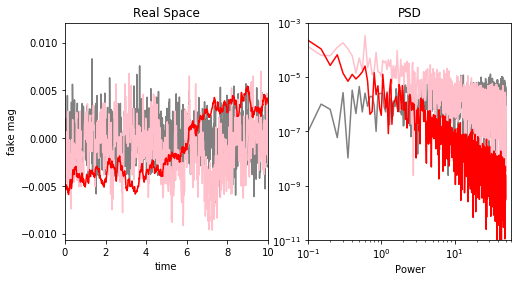

In [12]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(t, yWhite, c='Grey')
ax1.plot(t, yPink, c='Pink')
ax1.plot(t, yRed, '-r')
ax1.set_xlim(0, 10)
ax1.set_title('Real Space')
ax1.set_xlabel('time')
ax1.set_ylabel('fake mag')

ax2 = fig.add_subplot(122, xscale='log', yscale='log')
ax2.plot(fWhite, PSDwhite, c='Grey')   
ax2.plot(fPink, PSDpink, c='Pink')  
ax2.plot(fRed, PSDred, '-r')  
ax2.set_xlim(1E-1, 60)
ax2.set_ylim(1E-11, 1E-3)
ax2.set_xlabel('Frequency')
ax2.set_xlabel('Power')
ax2.set_title('PSD')

plt.show()

### ACF for Unevenly Sampled Data

astroML also has tools for computing the ACF of unevenly sampled data using two different (Scargle) and (Edelson & Krolik) methods: [http://www.astroml.org/modules/classes.html#module-astroML.time_series](http://www.astroml.org/modules/classes.html#module-astroML.time_series)

One of the tools is for generating a **damped random walk (DRW)**.  Above we found that a random walk had a $1/f^2$ PSD.  A *damped* random walk is a process "remembers" its history only for a characteristic time, $\tau$. The ACF vanishes for $\Delta t \gg \tau$.

In [13]:
# Syntax for EK and Scargle ACF computation
import numpy as np
from astroML.time_series import generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

t = np.arange(0,1000)
y = generate_damped_RW(t, tau=300)
dy = 0.1
y = np.random.normal(y,dy)

ACF_scargle, bins_scargle = ACF_scargle(t,y,dy)
ACF_EK, ACF_err_EK, bins_EK = ACF_EK(t,y,dy)

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


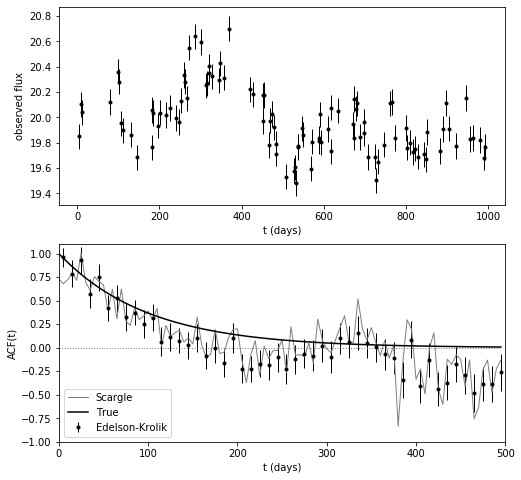

In [14]:
# Ivezic, Figure 10.30
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

#------------------------------------------------------------
# Generate time-series data:
#  we'll do 1000 days worth of magnitudes

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# compute ACF via scargle method
C_S, t_S = ACF_scargle(t, y_obs, dy, n_omega=2 ** 12, omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

#------------------------------------------------------------
# compute ACF via E-K method
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1, label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1, label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

plt.show()

# Next week

* (Continious) Autoregressive and Moving Average models 
* Gaussian Processes